# Model testing 18/01
This model was trained for 10 iterations using a normalization scheme subtracting the mean of that row from each row and dividing every row by the average standard deviation.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
sample_length = 128


Testing on house 2

In [3]:
aggregate_power = pd.read_csv('../master_data/house_2/channel_1.dat', header = None,
                                names = ["Time","Power"], delim_whitespace = True,
                                index_col = 0)
aggregate_power.index = pd.to_datetime(aggregate_power.index,unit='s')

kettle_power = pd.read_csv('../master_data/house_2/channel_8.dat', header = None,
                                names = ["Time","Power"], delim_whitespace = True,
                                index_col = 0)


kettle_power.head()

/home/bjornif/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Power
Time,
1361116822,0
1361116825,0
1361116831,0
1361116837,0
1361116843,0


In [4]:
def get_activations(power_series, min_off_duration=30, min_on_duration=12,
                        border=1, power_threshold=200):
    activations = []
    signal_start = None
    signal_end = None
    no_signal = 0
    current_signal = []
    series_length = len(power_series)
    series_length_percent = int(len(power_series)/100)
    measurements_processed = 0
    
    power_series.index = pd.to_datetime(power_series.index,unit='s')
    min_off_duration = pd.Timedelta(str(min_off_duration) + 's')
    min_on_duration = pd.Timedelta(str(min_off_duration) + 's')
    timestep = pd.Timedelta('6s')
    
    for time in power_series.index:
        measurement = power_series.loc[time]['Power']
        measurements_processed +=1
        
        if measurements_processed % series_length_percent == 0:
            print(str(measurements_processed/series_length_percent) + '%')
        
        if (measurement >= power_threshold):
            if signal_start is None:
                signal_start = time - timestep
            no_signal = 0
            current_signal.append(measurement)
            signal_end = time + timestep
            
        else:
            if signal_end is not None:
                no_signal = time - signal_end
                if (no_signal >= min_off_duration) and (signal_start is not None):
                    if (signal_end - signal_start) > min_on_duration:
                        mean_power = np.mean(current_signal)
                        activations.append([signal_start,signal_end,mean_power])
                    current_signal = []
                    signal_start = None
                    signal_end = None
    
    return activations

In [5]:
kettle_activations = get_activations(kettle_power)

1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%
100.0%


In [6]:
kettle_activations_pd = pd.DataFrame(kettle_activations, columns = ['start','end','mean_power'])
kettle_activations_pd['start'] = pd.to_datetime(kettle_activations_pd['start'])
kettle_activations_pd['end'] = pd.to_datetime(kettle_activations_pd['end'])

kettle_activations_pd.head()

,start,end,mean_power
0,2013-04-17 08:01:11,2013-04-17 08:03:11,2846.210526
1,2013-04-17 16:23:28,2013-04-17 16:26:22,3016.071429
2,2013-04-17 19:11:30,2013-04-17 19:15:12,2897.971429
3,2013-04-17 20:40:15,2013-04-17 20:43:21,2998.500000
4,2013-04-18 15:32:01,2013-04-18 15:35:01,3007.241379


2013-04-21 18:21:36 2013-04-21 18:25:19


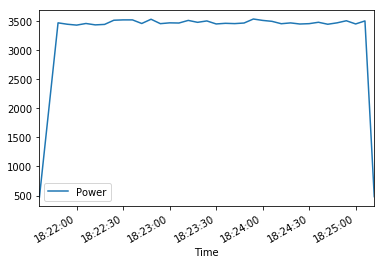

In [7]:
for _ in range(1):
    dice = np.random.randint(0,100)
    start = kettle_activations_pd.iloc[dice]['start']
    end = kettle_activations_pd.iloc[dice]['end']
    print(start,end)
    aggregate_power[start:end].plot()
    plt.show()

In [8]:
def clean_power_series(aggregate_power, activations):
    
    temp_ap = aggregate_power.copy()
    
    n = activations.shape[0]

    #pcent = int(n/100)
    ap_sans_activations = pd.DataFrame()
    
    ap_sans_activations.append(temp_ap[:activations['start'][0]])
    
    for i in range(1,n):
        ap_sans_activations = ap_sans_activations.append(temp_ap[activations['end'][i-1]:activations['start'][i]])
    
    ap_sans_activations.append(temp_ap[activations['end'][i]:])
    
    return ap_sans_activations


def create_training_set(aggregate_power, activations, ap_sans_activations = None, sample_length = 128, pad = 1024):
    training_set = pd.DataFrame(columns = np.linspace(0,1,sample_length))
    training_set_response = pd.DataFrame(columns = ['start','end','mean_power'])

    #aggregate power sans the activation intervals
    if ap_sans_activations is None:
        ap_sans_activations = clean_power_series(aggregate_power,activations)

    n = aggregate_power.shape[0]
    j = 0
    for i in range(activations.shape[0]):
        if i % 100 == 0:
            print(i)
        while True:
            dice = np.random.random()
            if dice < 0.5:
                start = activations['start'][i]
                end = activations['end'][i]
                #randomly place the chosen signal in a window.
                #note that the entire signal is always in the window 
                sample_start = start - pd.Timedelta(np.random.randint(0,pad),unit='s')
                sample_end = end + pd.Timedelta(np.random.randint(0,pad),unit='s')
                sample = aggregate_power[sample_start:sample_end]

                while sample.shape[0] > sample_length:
                    if np.random.random() > 0.5 and end < sample.index[-1]:
                        sample = sample.iloc[:-1]
                    elif start > sample.index[0]:
                        sample = sample.iloc[1:]
                    else:
                        sample = sample.iloc[0:1]
                
                if not sample.shape[0] < sample_length:
                    
                    #sample = sample.reindex(columns=training_set.columns, method='nearest')
                    start_fraction = (start - sample.index[0])/(sample.index[-1] - sample.index[0])
                    end_fraction = (end - sample.index[0])/(sample.index[-1] - sample.index[0])
                    training_set.loc[j] = sample.T.values[0]
                    training_set_response.loc[j] = [start_fraction,end_fraction,activations['mean_power'][i]]
                    j+=1
                
                break
                
                
            ri = np.random.randint(0,ap_sans_activations.shape[0]-sample_length)
            sample = ap_sans_activations.iloc[ri: ri+sample_length]
            training_set.loc[j] = sample.T.values[0]
            training_set_response.loc[j] = [0,0,0]
            j+=1
            
    return training_set, training_set_response



#### Note: 
drop() takes forever, avoid it.<br>


In [9]:
clean_ap = clean_power_series(aggregate_power,kettle_activations_pd)

In [10]:
X, y = create_training_set(aggregate_power, kettle_activations_pd,
                                            ap_sans_activations = clean_ap,
                                            sample_length = sample_length)
X.head()

0
100
200
300
400
500
600
700


,0.0,0.00787401574803,0.0157480314961,0.0236220472441,0.0314960629921,0.0393700787402,0.0472440944882,0.0551181102362,0.0629921259843,0.0708661417323,...,0.929133858268,0.937007874016,0.944881889764,0.952755905512,0.96062992126,0.968503937008,0.976377952756,0.984251968504,0.992125984252,1.0
0,227,228,229,222,228,225,225,224,223,223,...,231,226,230,228,232,229,232,225,230,225
1,251,261,266,261,254,250,250,255,259,251,...,207,222,210,214,209,212,209,210,209,211
2,333,332,326,320,323,324,328,324,319,327,...,3410,3373,3407,3393,3372,3378,3383,3428,3428,384
3,209,209,207,212,216,225,210,208,209,213,...,261,264,263,263,260,259,260,261,259,263
4,130,130,130,131,131,131,133,133,129,133,...,184,186,188,186,184,185,186,183,182,182


In [112]:
from keras.models import load_model

model = load_model('../master_data/nilm/models/model0119b.h5')


In [93]:
normalization = pd.read_csv('../master_data/nilm/normalization_params.csv', header=0, delim_whitespace=True)
normalization.head()

,mean,sd
0,[[[ 813.625 ]]\n\n [[ 573.9296875]]\n\n [[ ...,560.485032


In [113]:
X_np = np.array(X).reshape((X.shape[0],X.shape[1],1))
y_np = np.array(y).reshape((y.shape[0],y.shape[1]))

#mean = normalization['mean'].values[0]
mean = X_np.mean(axis=1).reshape(X_np.shape[0],1,1)
X_np = X_np - mean
sd = normalization['sd'].values[0]
#rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
X_np /= sd
print("Mean: ", X_np.mean())
print("Std: ", X_np.std())


Mean:  -4.982937977843506e-16
Std:  1.43280643862


(1414, 1)


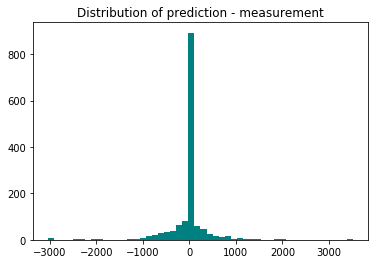

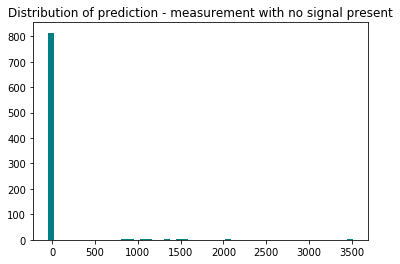

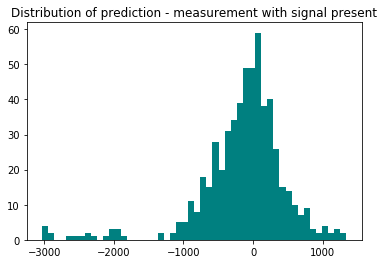

In [114]:

pred = model.predict(X_np)

#Scale experiment:
pred[:,0] = pred[:,0]/1000
pred[:,1] = pred[:,1]/1000

diff_power = pred[:,2] - y_np[:,2]
diff_power = diff_power.reshape(diff_power.shape[0],1)
diff_clean = pred[:,2][y_np[:,2] == 0] - y_np[:,2][y_np[:,2] == 0]
diff_clean = diff_clean.reshape(diff_clean.shape[0],1)
diff_signal = pred[:,2][y_np[:,2] != 0] - y_np[:,2][y_np[:,2] != 0]
diff_signal = diff_signal.reshape(diff_signal.shape[0],1)

print(diff_power.shape)

plt.hist(diff_power,bins=50, color='teal')
plt.title("Distribution of prediction - measurement")
plt.show()

plt.hist(diff_clean,bins=50, color='teal')
plt.title("Distribution of prediction - measurement with no signal present")
plt.show()

plt.hist(diff_signal,bins=50, color='teal')
plt.title("Distribution of prediction - measurement with signal present")
plt.show()

As seen previously, the model seems to predict fairly well whether or not a signal is present. With this normalization scheme it also appears to find good estimates of power consumption and signal start and end times.

Best F1:  0.974313551816


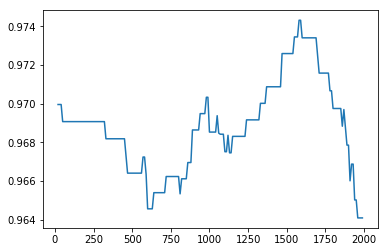

In [115]:
#F1 score = 2*(recall*precision)/(recall+precision)
signal_present_gold = np.zeros(pred.shape[0])
signal_present_gold[np.where(y_np[:,2] > 0)] = 1
accs = []
thresholds = np.arange(20,2000,10)

for i in thresholds:
    signal_present_pred = np.zeros(pred.shape[0])
    signal_present_pred[np.where(pred[:,2] >= i)] = 1
    
    precision = signal_present_gold[signal_present_gold + signal_present_pred == 2].shape[0]/np.sum(signal_present_pred)
    recall = signal_present_gold[signal_present_gold + signal_present_pred == 2].shape[0]/np.sum(signal_present_gold)
    f1 = 2*(recall*precision)/(recall+precision)
    
    accs.append(f1)
    
print("Best F1: ", max(accs))
plt.plot(thresholds,accs)
plt.xticks = thresholds
plt.show()


Thresholding around 1500W allows for a >99% F1 score.

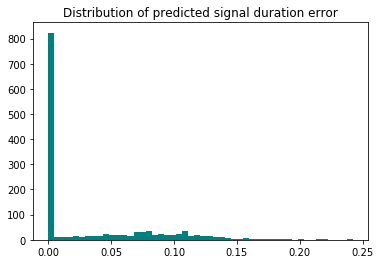

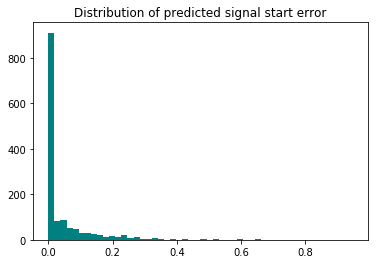

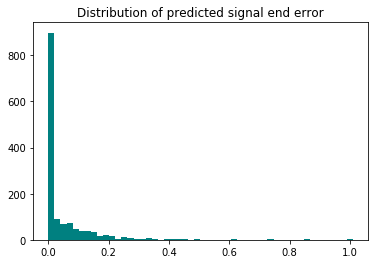

In [116]:
#Error in duration:

duration_pred = pred[:,1] - pred[:,0]
duration_measured = y_np[:,1] - y_np[:,0]
sane_index = np.where(np.logical_and(duration_pred < 1,duration_pred > 0))
sane_duration_pred  = duration_pred[sane_index]
sane_duration_measured = duration_measured[sane_index]

duration_mae = np.abs(duration_pred - duration_measured)
duration_mae = duration_mae.reshape(duration_mae.shape[0],1)
sane_duration_mae = np.abs(sane_duration_pred - sane_duration_measured).mean()

plt.clf()
plt.hist(duration_mae,bins = 50, color='teal')
plt.title("Distribution of predicted signal duration error")
plt.show()

start_diff = np.abs(pred[:,0] - y_np[:,0])
start_diff = start_diff.reshape(start_diff.shape[0],1)

plt.hist(start_diff,bins = 50, color='teal')
plt.title("Distribution of predicted signal start error")
plt.show()

end_diff = np.abs(pred[:,1] - y_np[:,1])
end_diff = end_diff.reshape(end_diff.shape[0],1)

plt.hist(end_diff,bins = 50, color='teal')
plt.title("Distribution of predicted signal end error")
plt.show()

The scale of the interval outputs make a large difference for the ability of the model to discover the correct intervals. When normalized to [0,1], the model, basing its loss function on the mean square error, naturally focuses more on the mean_power output, which is three orders of magnitude larger, and thus generates a far greater loss.

## Discussion
### Normalization
A normalization scheme similar to what Kelly proposed - subtracting the mean from each row, but dividing all inputs by the average standard deviation of all rows - seems to work the best. Other normalization schemes tested include no normalization, no centering, neither, centering by average mean and normalizing with random deviations.<br>

### Training
Surprisingly, the model does not seem to benefit much from extensive training, and can be trained in a single epoch to a reasonable degree, taking around 2-3 minutes. This is in stark contrast to the training times reported by Kelly.<br><br>
One neat discovery was that scaling the range of the time components of the output to be the same order of magnitude as the power component, allowed the net to focus more on this part of the loss (now non-neglible). Perhaps the reason this is not more commonly covered in literature is because of the rarity of training multiple regression nets.<br><br>
Also surprising is the fact that by thresholding appropriately I am able to acheive a far better F1 score than Kelly on the kettle.